In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [18]:
# Members of the intersection of both the 115th and 116th US Congress
# All of these members where there during the whole 2016-2020 period (both 115th & 116th congress)
congress = pd.read_csv("/content/drive/MyDrive/ADA/congress_115_116.csv")

In [19]:
congress.head()

,Unnamed: 0,fec_candidate_id,speaker,short_title,last_name,first_name,party,date_of_birth,gender,state
0,0,H4LA05221,ralph abraham,Rep.,Abraham,Ralph,R,1954-09-16,M,LA
1,1,H4NC12100,alma adams,Rep.,Adams,Alma,D,1946-05-27,F,NC
2,2,H6AL04098,robert aderholt,Rep.,Aderholt,Robert,R,1965-07-22,M,AL
3,3,H2CA31125,pete aguilar,Rep.,Aguilar,Pete,D,1979-06-19,M,CA
4,4,H2GA12121,rick allen,Rep.,Allen,Rick,R,1951-11-07,M,GA


In [20]:
%%time 
# link to the Drive repo + the year of the newpapers quotes
path_to_file = '/content/drive/MyDrive/ADA/quotes-2020-congress-speakers.json.bz2'
# here the data is in the ADA folder placed at the root of your Drive

quotes_2020_congress = []
with bz2.open(path_to_file, 'rb') as s_file:
    for i, sample in enumerate(s_file):
      quote = json.loads(sample)
      quotes_2020_congress.append(quote)

CPU times: user 7.49 s, sys: 221 ms, total: 7.71 s
Wall time: 7.74 s


In [21]:
# Transforming the array of quotes in a pandas DataFrame
df_2020_congress = pd.DataFrame(quotes_2020_congress)
df_2020_congress.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-02-02-000235,"... Under a President Biden, the possibilities...",Danny Davis,"[Q5220272, Q5220273]",2020-02-02 16:38:56,1,"[[Danny Davis, 0.5771], [None, 0.4229]]",[https://chicago.suntimes.com/news/2020/2/2/21...,E
1,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,[Q771586],2020-01-26 13:21:36,11,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...,E
2,2020-03-24-005548,arts workers are right up there. They are alre...,Chellie Pingree,[Q457243],2020-03-24 00:28:24,1,"[[Chellie Pingree, 0.7979], [None, 0.2021]]",[https://www.centralmaine.com/2020/03/23/arts-...,E
3,2020-03-03-006838,"Bernie's argument is, `Don't pigeonhole me as ...",Dan Kildee,[Q3880272],2020-03-03 03:41:00,1,"[[Dan Kildee, 0.8965], [None, 0.0857], [Bernie...",[http://www.msn.com/en-us/news/elections-2020/...,E
4,2020-01-15-014697,cross a very important threshold in American h...,Nancy Pelosi,[Q170581],2020-01-15 18:58:16,1,"[[Nancy Pelosi, 0.8052], [None, 0.1902], [Pres...",[http://thehill.com/homenews/house/478429-pelo...,E


In [22]:
# Counting the number of quotes by each member of the congress
df_2020_congress["speaker"].str.lower().value_counts()

elizabeth warren    7672
nancy pelosi        5656
amy klobuchar       3768
adam schiff         3624
mitch mcconnell     3355
                    ... 
anthony b              1
michael b              1
thomas suozzi          1
joaquín castro         1
adam k                 1
Name: speaker, Length: 395, dtype: int64

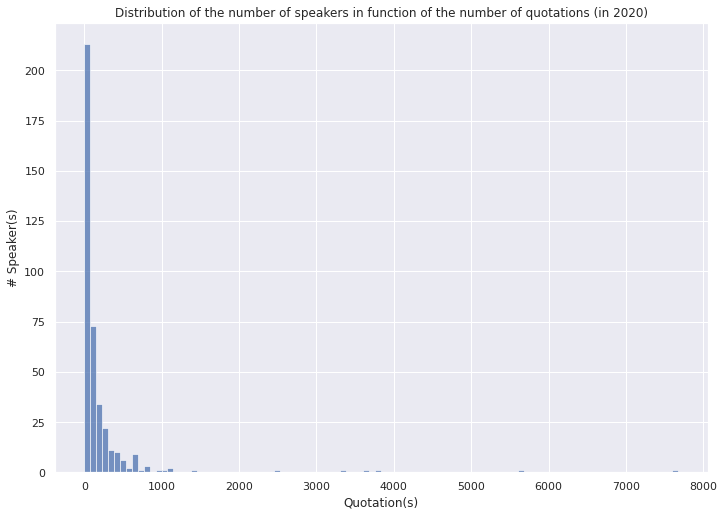

CPU times: user 574 ms, sys: 8.78 ms, total: 583 ms
Wall time: 581 ms


In [23]:
%%time
# Distribution of the number(#) of speakers in function of the # of quotes

ax11 = sns.histplot(data = df_2020_congress["speaker"].str.lower().value_counts(), bins=100)
ax11.set_title('Distribution of the number of speakers in function of the number of quotations (in 2020)')
ax11.set_ylabel('# Speaker(s)')
ax11.set_xlabel('Quotation(s)')
plt.show()

In [24]:
df_2020_congress["speaker"] = df_2020_congress["speaker"].str.lower()
df_2020_congress_merged = pd.merge(df_2020_congress, congress[["speaker", "party", "gender", "date_of_birth", 'state']], on=["speaker"], how='left')
df_2020_congress_merged.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party,gender,date_of_birth,state
0,2020-02-02-000235,"... Under a President Biden, the possibilities...",danny davis,"[Q5220272, Q5220273]",2020-02-02 16:38:56,1,"[[Danny Davis, 0.5771], [None, 0.4229]]",[https://chicago.suntimes.com/news/2020/2/2/21...,E,D,M,1941-09-06,IL
1,2020-01-26-000499,a few of the candidates who will do better in ...,dave loebsack,[Q771586],2020-01-26 13:21:36,11,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...,E,D,M,1952-12-23,IA
2,2020-03-24-005548,arts workers are right up there. They are alre...,chellie pingree,[Q457243],2020-03-24 00:28:24,1,"[[Chellie Pingree, 0.7979], [None, 0.2021]]",[https://www.centralmaine.com/2020/03/23/arts-...,E,D,F,1955-04-02,ME
3,2020-03-03-006838,"Bernie's argument is, `Don't pigeonhole me as ...",dan kildee,[Q3880272],2020-03-03 03:41:00,1,"[[Dan Kildee, 0.8965], [None, 0.0857], [Bernie...",[http://www.msn.com/en-us/news/elections-2020/...,E,D,M,1958-08-11,MI
4,2020-01-15-014697,cross a very important threshold in American h...,nancy pelosi,[Q170581],2020-01-15 18:58:16,1,"[[Nancy Pelosi, 0.8052], [None, 0.1902], [Pres...",[http://thehill.com/homenews/house/478429-pelo...,E,D,F,1940-03-26,CA


In [25]:
# Number of quotes for this dataset
quotes_number_2020 = df_2020_congress_merged.shape[0]
print(f' Total number of quotes for congress dataset 2020: {quotes_number_2020}')

 Total number of quotes for congress dataset 2020: 80180


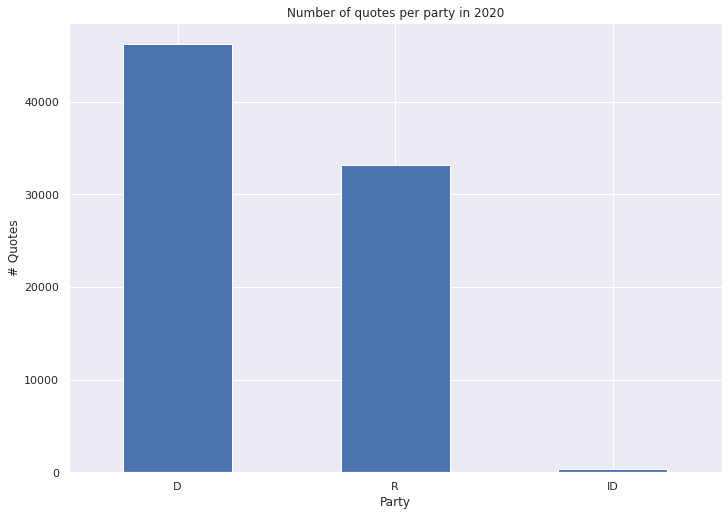

,party
D,46209
R,33168
ID,325


In [26]:
#-------------------Political party------------------------

df_party = df_2020_congress_merged['party'].value_counts().to_frame()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax2 = df_party.plot(kind='bar', rot=0, legend = False)
ax2.set_title("Number of quotes per party in 2020")
ax2.set_ylabel('# Quotes')
ax2.set_xlabel('Party')
plt.show()
df_party

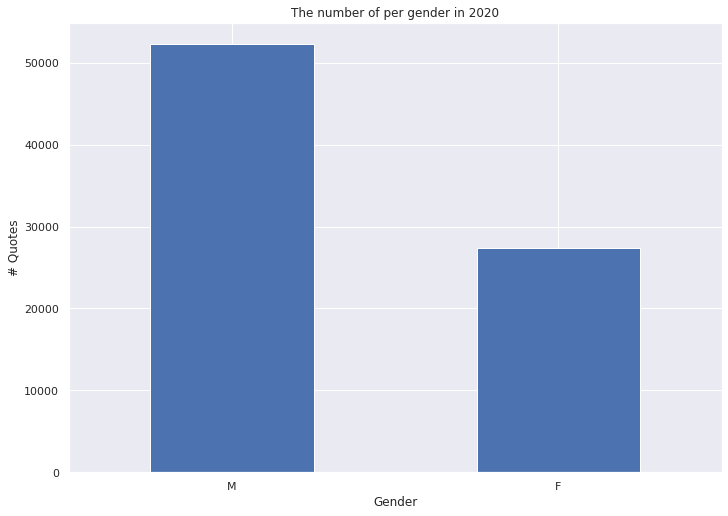

,gender
M,52269
F,27433


In [27]:
#-----------------Gender-----------------

df_gender = df_2020_congress_merged['gender'].value_counts().to_frame()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax3 = df_gender.plot(kind='bar', rot=0, legend = False)
ax3.set_title('The number of per gender in 2020')
ax3.set_ylabel('# Quotes')
ax3.set_xlabel('Gender')
plt.show()
df_gender

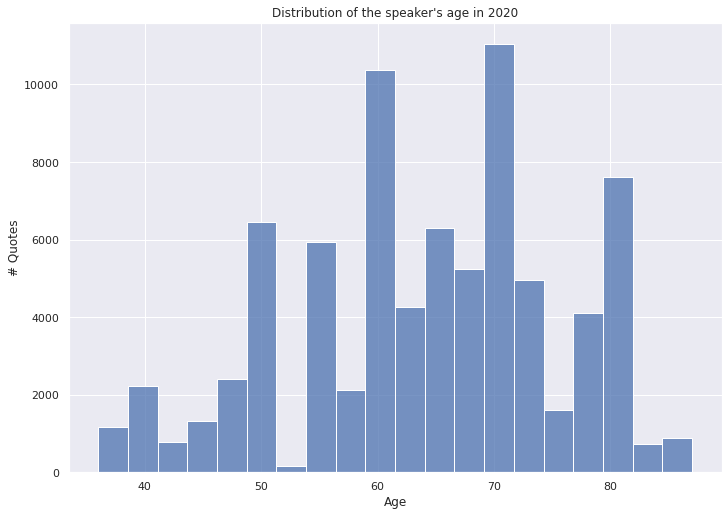

,age
mean,64.073612
50%,65.000000
min,36.000000
max,87.000000


In [28]:
#-----------------Age-----------------

df_2020_congress_merged['year_of_birth'] = pd.DatetimeIndex(df_2020_congress_merged['date_of_birth']).year.astype('Int64')
df_2020_congress_merged['age'] = (2020 - df_2020_congress_merged['year_of_birth']).astype('Int64')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax3 = sns.histplot(data = df_2020_congress_merged['age'], bins=20)
ax3.set_title("Distribution of the speaker's age in 2020")
ax3.set_ylabel('# Quotes')
ax3.set_xlabel('Age')
plt.show()

df_2020_congress_merged.describe().loc[['mean', '50%', 'min', 'max'],['age']]


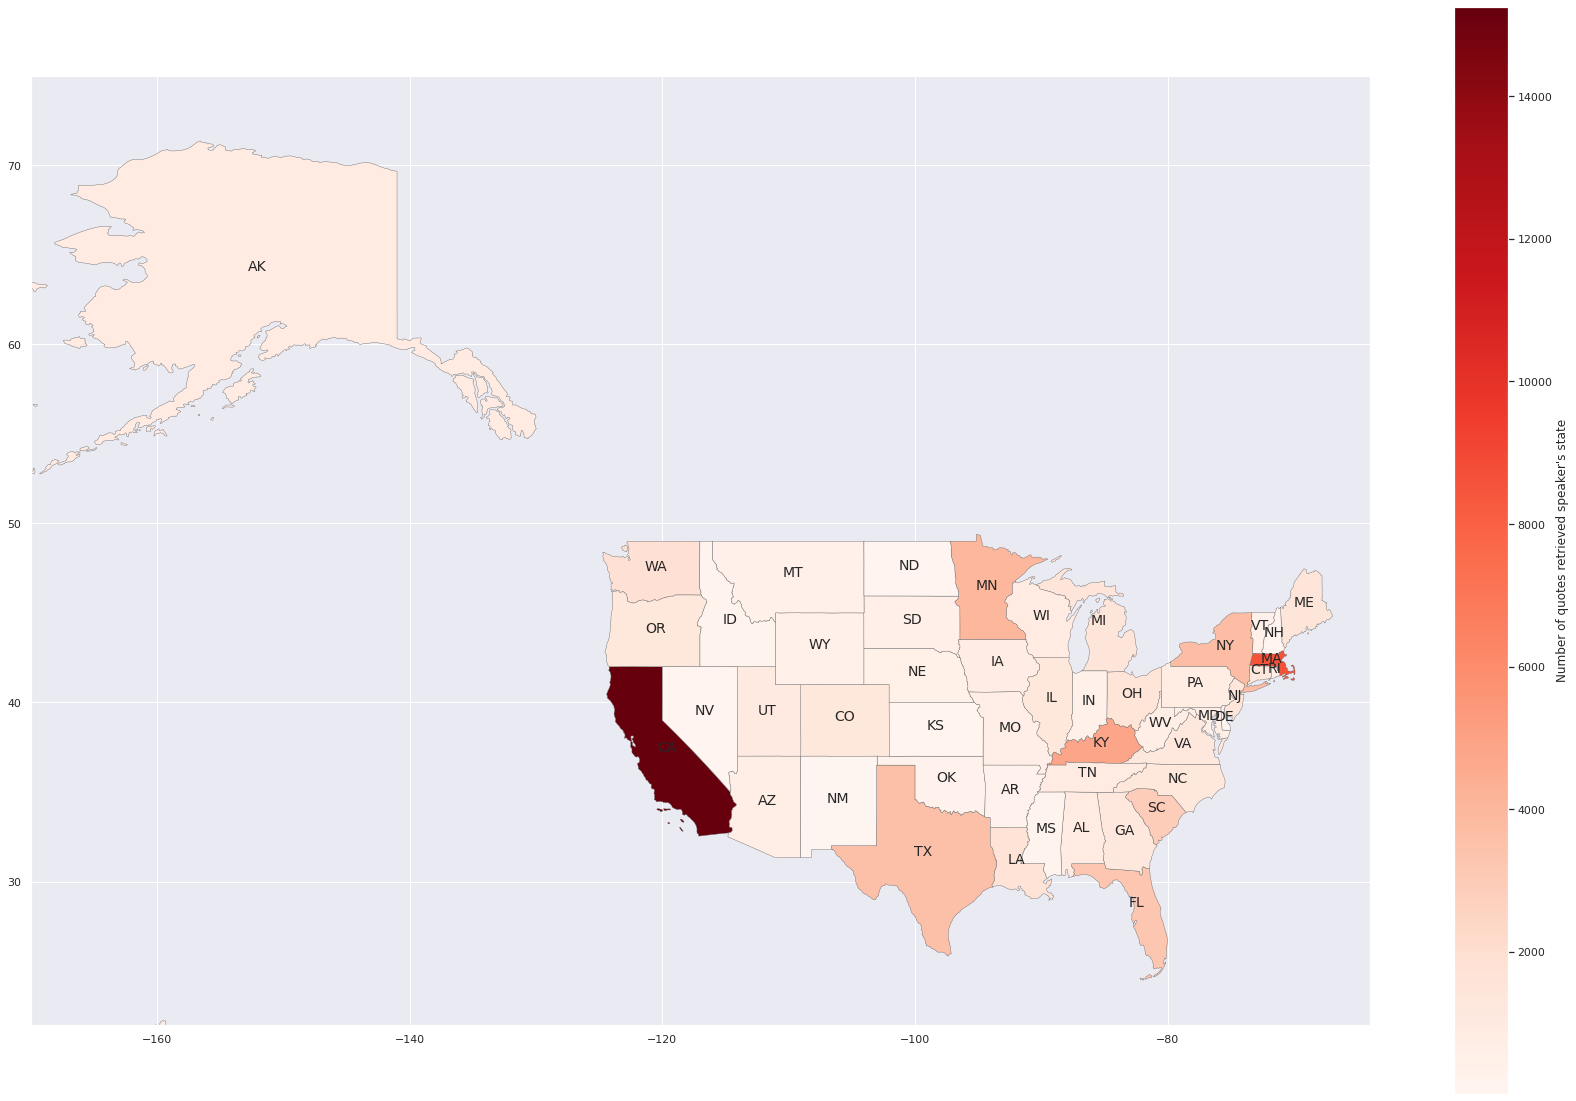

In [34]:
#--------------------State-----------------------
# Heatmap of occurences of state origin of speaker 
!pip install geopandas #to run once
import geopandas as gpd
from geopandas import GeoDataFrame
states_map = gpd.read_file("/content/drive/MyDrive/map/cb_2018_us_state_20m.shp")

fig, ax = plt.subplots(1, figsize=(30, 20))
df_state = df_2020_congress_merged['state'].value_counts().to_frame()
merged = df_state.merge(states_map, left_index=True, right_on='STUSPS')
merged = GeoDataFrame(merged)
merged.apply(lambda x: ax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1);
merged.plot(column="state", cmap="Reds", ax=ax, linewidth=0.4, edgecolor=".4", legend=True, legend_kwds={'label': "Number of quotes retrieved speaker's state", 'orientation': "vertical"})
_ = ax.set_xlim([-170, -64])
_ = ax.set_ylim([22, 75])


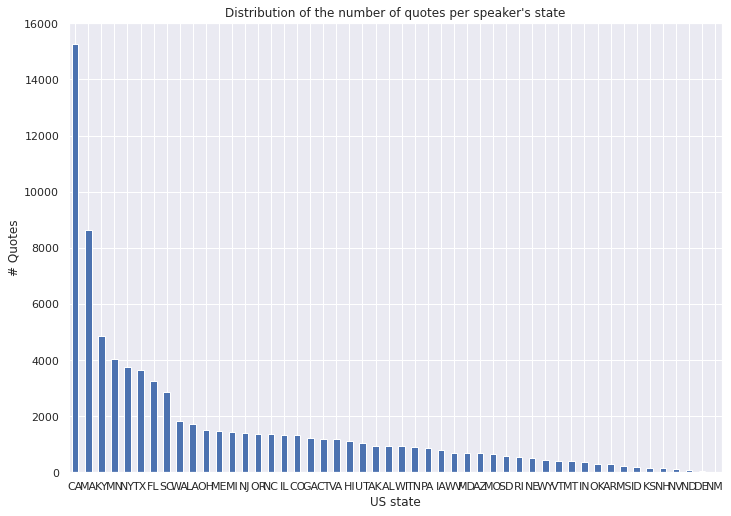

In [35]:
ax2 = df_state.plot(kind='bar', rot=0, legend = False)
ax2.set_title("Distribution of the number of quotes per speaker's state")
ax2.set_ylabel('# Quotes')
ax2.set_xlabel('US state')
plt.show()

In [31]:
# Number of quotes containing the string "climate change"

num_quotes_climate_change = np.count_nonzero(df_2020_congress_merged['quotation'].str.count('climate change'), axis=0)
print(f'Number of quotes containing the string "climate change": {num_quotes_climate_change}')

Number of quotes containing the string "climate change": 156


In [32]:
# Number of quotes containing the string 'Paris agreement'

num_quotes_paris = np.count_nonzero(df_2020_congress_merged['quotation'].str.count('Paris agreement'), axis=0)
print(f'Number of quotes containing the string "Paris agreement": {num_quotes_paris}')

Number of quotes containing the string "Paris agreement": 0


In [33]:
# Number of quotes containing the string "health insurances"

num_quotes_health_insurance = np.count_nonzero(df_2020_congress_merged['quotation'].str.count('health insurance'), axis=0)
print(f'Number of quotes containing the string "health insurances": {num_quotes_health_insurance}')

Number of quotes containing the string "health insurances": 57
